# Анализ поведения пользователей мобильного приложения

Цель проекта:
 - определить по результатам A/A/B-теста, какой шрифт лучше использовать в приложении

Для проведения анализа имеется лог данных:
 - EventName — название события;
 - DeviceIDHash — уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

План выполнения задачи:

1. [Общая информация](#start)
2. [Изучение данных](#data)
3. [Воронка событий](#funnel)
4. [Результаты эксперимента](#results)   
5. [Вывод](#end)

## Общая информация
<a id="start"></a>

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from datetime import datetime
import math as mth
import scipy.stats as stats
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

Открываем файл и смотрим информацию

In [2]:
df = pd.read_csv('datasets.csv', sep='\t')

In [3]:
display(df.head())
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Переименуем столбцы

In [4]:
df = df.rename(columns={'EventName': 'event', 'DeviceIDHash': 'id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'group'})

Изменит тип данных в столбце 'event' на тип 'category'

In [5]:
df['event'] = df['event'].astype('category')

Добавим столбец даты и времени 'event_timedate', а также отдельный столбец дат 'event_date'

In [6]:
df['event_timedate'] = pd.to_datetime(df['event_timestamp'], unit="s")

In [7]:
df['event_date'] = df['event_timedate'].dt.date

Посмотрим на наличие дубликатов и удалим их

In [8]:
df[df.duplicated(subset=['id', 'event', 'group', 'event_timedate'], keep = False)]

,event,id,event_timestamp,group,event_timedate,event_date
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2348,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3572,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
...,...,...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242362,CartScreenAppear,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242634,MainScreenAppear,4097782667445790512,1565206618,246,2019-08-07 19:36:58,2019-08-07


In [9]:
df = df.drop_duplicates(subset=['id', 'event', 'group', 'event_timedate'], keep = 'last')

Мы ознакомились с данными, привели столбец 'event' к типу 'category', удалили дубликаты (скорее всего они появились при выгрузке, возможно произошел технический сбой). Пропуски в данных отсутствуют.

## Изучение данных
<a id="data"></a>

Найдем количество событий в логе

In [10]:
df['event'].count()

243713

In [11]:
df['event'].unique()

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']

Найдем количество пользователей в логе

In [12]:
df['id'].nunique()

7551

Нйдем среднее количество событий на пользователя

In [13]:
df['event'].count() / df['id'].nunique()

32.27559263673685

Найдем максимальную и минимальную дату периода

In [14]:
df['event_timedate'].min()

Timestamp('2019-07-25 04:43:36')

In [15]:
df['event_timedate'].max()

Timestamp('2019-08-07 21:15:17')

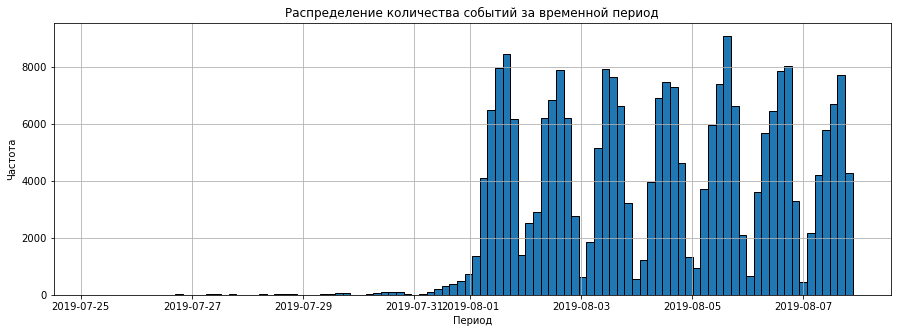

In [16]:
df['event_timedate'].hist(bins = 100, ec='black', figsize = (15, 5))
plt.xlabel('Период')
plt.ylabel('Частота')
plt.title('Распределение количества событий за временной период')
plt.show()

Рассмотрев полученные результаты, видим, что до начала августа данных практически нет, присутствует совсем маленькое количество. Поэтому для дальнейших дейтсвий мы не будем использовать данные до 01.08.2019

Найдем количество событий и пользователей в данных до 01.08.2019

In [17]:
df_drop= df[df['event_timedate'] < '2019-08-01']

In [18]:
df_drop['id'].nunique()

1451

In [19]:
df_drop['event'].count()

2826

Удалим данные до 01.08.2019

In [20]:
df = df[df['event_timedate'] >= '2019-08-01']

In [21]:
df['id'].nunique()

7534

Найдем количество пользователей, которые совершали события до 01.08.2019

In [22]:
7551 - 7534

17

Проверим имеются ли у нас пользователи, которые совершали события и до 01.08.2019 и после этой даты.

In [23]:
dublicate = df[df['id'].isin(df_drop['id'])]

In [24]:
dublicate['id'].nunique()

1434

Да, такие пользователи есть.

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [25]:
df.groupby('group')['id'].nunique()

group
246    2484
247    2513
248    2537
Name: id, dtype: int64

В ходе этого шага мы обнаружили, что до 01.08.2019 у нас имелись не полные данные. Поэтому для проведения дальнейшего анализа мы отбросили все данные до этой даты(события , которые совершали 17 пользователей).

## Воронка событий
<a id="funnel"></a>

Найдем какие события есть в логах и как часто они встречаются

In [26]:
df['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

Найдем сколько пользователей совершали каждое из этих событий

In [27]:
df_1 = df.groupby('event')['id'].nunique().reset_index().sort_values(by='id', ascending = False)

Мы видим событие 'Tutorial', которое возможно пройти на любом шаге. И как мы видим по количеству польвателей, этот шаг необязательный, его можно пропустить при переходе на другой шаг. Исключим это событие при построении воронки событий.

Добавим к датасету первоначальные данные о посетителях

In [28]:
df_1.loc[5] = ['Visits', 7534]

Найдем конверсии пользователей на каждом шаге

In [29]:
df_1['conversion'] = df_1['id'] / 7534

In [30]:
df_1 = df_1.sort_values(by='id', ascending = False)

In [31]:
df_1

,event,id,conversion
5,Visits,7534,1.000000
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Построим воронку событий

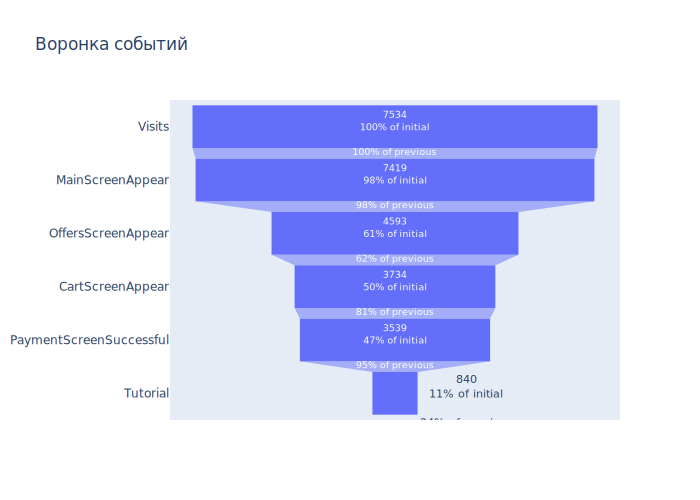

In [32]:
fig = go.Figure(
    go.Funnel(
        y=df_1['event'],
        x=df_1['id'],
        textinfo = "value+percent initial+percent previous",
    )
)
fig.update_layout(title='Воронка событий')
fig.show(renderer='svg') 

По воронке событий мы видим, что доля пользователей, которые проходят на следующий шаг составляет:
  - MainScreenAppear - 98% от предыдущего шага, 98% от первоначального шага
  - OffersScreenAppear - 62% от предыдущего шага, 61% от первоначального шага
  - CartScreenAppear - 81% от предыдущего шага, 50% от первоначального шага
  - PaymentScreenSuccessful	- 95% от предыдущего шага, 47% от первоначального шага
  
Больше всего пользователей было потеряно при переходе на 'OffersScreenAppear'.

47%  пользователей доходит от первого события до оплаты.

## Результаты эксперимента
<a id="results"></a>

Найдем количество пользователей для каждой экспериментальной группы

In [33]:
df.groupby('group')['id'].nunique()

group
246    2484
247    2513
248    2537
Name: id, dtype: int64

Проверим наличие пересекающихся пользователей по группам

In [34]:
group246 = df.query('group == "246"')['id'].tolist()
group247 = df.query('group == "247"')['id'].tolist()
group248 = df.query('group == "248"')['id'].tolist()

In [35]:
len(set(group246)&set(group247)&set(group248))

0

Таких пользователей нет.

Найдем распределение пользоватей по группам и событиям

In [36]:
data = df.pivot_table(index = 'event', 
                      columns = 'group', values = 'id', aggfunc = 'nunique').reset_index()

In [37]:
data.columns = ['event','A1', 'A2', 'B']

In [38]:
data = data.sort_values(by=['A1', 'A2', 'B'], ascending = False)
data

,event,A1,A2,B
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [39]:
data.loc[5] = ['Visits', 2484, 2513, 2537]

In [40]:
data

,event,A1,A2,B
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279
5,Visits,2484,2513,2537


In [41]:
re_i = [5, 1, 2, 0, 3, 4]
data = data.reindex(re_i)

In [42]:
data

,event,A1,A2,B
5,Visits,2484,2513,2537
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [43]:
data.loc[5, 'A2']

2513

Создадим массивы событий по количеству уникальных пользователей

In [44]:
total_A1 = 2484
tolal_A2 = 2513
total_B = 2537

In [45]:
MainScreenAppear = np.array([2450, 2476, 2493])
OffersScreenAppear = np.array([1542, 1520, 1531])
CartScreenAppear = np.array([1266, 1238, 1230])
PaymentScreenSuccessful = np.array([1200, 1158, 1181])

Создадим функцию, которая проверяет находят ли статистические критерии разницу между выборками

In [46]:
def hypothesis(event_1, event_2, total_1, total_2):
    alpha=0.05
    
    p1 = event_1/total_1
    p2 = event_2/total_2
    p_combined = (event_1 + event_2) / (total_1 + total_2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_1 + 1 / total_2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Сформируем гипотезы:
 
 - Н0 - статистически значимых различий нет между долями пользователей, совершающих событие
 - Н1 - статистически значимые различия есть между долями пользователей, совершающих событие

Проверим группы 246 и 247

Шаг 1-2-3-4

In [47]:
hypothesis(data.loc[1, 'A1'], data.loc[1, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])
hypothesis(data.loc[2, 'A1'], data.loc[2, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])
hypothesis(data.loc[0, 'A1'], data.loc[0, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])
hypothesis(data.loc[3, 'A1'], data.loc[3, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим группы 246 и 248

Шаг 1-2-3-4

In [48]:
hypothesis(data.loc[1, 'A1'], data.loc[1, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis(data.loc[2, 'A1'], data.loc[2, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis(data.loc[0, 'A1'], data.loc[0, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis(data.loc[3, 'A1'], data.loc[3, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим группы 247 и 248

Шаг 1-2-3-4

In [49]:
hypothesis(data.loc[1, 'A2'], data.loc[1, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis(data.loc[2, 'A2'], data.loc[2, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis(data.loc[0, 'A2'], data.loc[0, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis(data.loc[3, 'A2'], data.loc[3, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим объединённую контрольную группу с группой 248

Шаг 1-2-3-4

In [50]:
hypothesis(data.loc[1, 'A1'] + data.loc[1, 'A2'], data.loc[1, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis(data.loc[2, 'A1'] + data.loc[2, 'A2'], data.loc[2, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis(data.loc[0, 'A1'] + data.loc[0, 'A2'], data.loc[0, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis(data.loc[3, 'A1'] + data.loc[3, 'A2'], data.loc[3, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], data.loc[5, 'B'])

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При проверке всех гипотез не получилось отвергнуть Н0, основая считать доли пользователей, совершивший событие, различными нет.

Уровень статистической значимости для проверки гипотез был выбран в 0.05. Всего было проведено 12 проверок, что считается множественным тестом. Особенность множественных тестов состоит в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Применим метод Шидака, чтобы снизить такую вероятность.

Создадим функцию для проверки

In [51]:
sidak_alpha = 1 - (1 - 0.05)**(1/12)

In [52]:
def hypothesis_sidak(event_1, event_2, total_1, total_2):
    alpha=sidak_alpha
    
    p1 = event_1/total_1
    p2 = event_2/total_2
    p_combined = (event_1 + event_2) / (total_1 + total_2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_1 + 1 / total_2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', '{0:.10f}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Проверим группы 246 и 247, шаги 1-2-3-4

In [53]:
hypothesis_sidak(data.loc[1, 'A1'], data.loc[1, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[2, 'A1'], data.loc[2, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])
hypothesis_sidak(data.loc[0, 'A1'], data.loc[0, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])
hypothesis_sidak(data.loc[3, 'A1'], data.loc[3, 'A2'], data.loc[5, 'A1'], data.loc[5, 'A2'])

p-значение:  0.2949721934
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2288337224
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.1145667931
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим группы 246 и 248, шаги 1-2-3-4

In [54]:
hypothesis_sidak(data.loc[1, 'A1'], data.loc[1, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[2, 'A1'], data.loc[2, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[0, 'A1'], data.loc[0, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[3, 'A1'], data.loc[3, 'B'], data.loc[5, 'A1'], data.loc[5, 'B'])

p-значение:  0.2949721934
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2083620540
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.0784292324
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553276
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим группы 247 и 248, шаги 1-2-3-4

In [55]:
hypothesis_sidak(data.loc[1, 'A2'], data.loc[1, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[2, 'A2'], data.loc[2, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[0, 'A2'], data.loc[0, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])
hypothesis_sidak(data.loc[3, 'A2'], data.loc[3, 'B'], data.loc[5, 'A2'], data.loc[5, 'B'])

p-значение:  0.4587053617
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817831
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197880
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415054
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим  объединённую контрольную группу с группой 248, шаги 1-2-3-4

In [56]:
hypothesis_sidak(data.loc[1, 'A1'] + data.loc[1, 'A2'], data.loc[1, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], 
                 data.loc[5, 'B'])
hypothesis_sidak(data.loc[2, 'A1'] + data.loc[2, 'A2'], data.loc[2, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], 
                 data.loc[5, 'B'])
hypothesis_sidak(data.loc[0, 'A1'] + data.loc[0, 'A2'], data.loc[0, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], 
                 data.loc[5, 'B'])
hypothesis_sidak(data.loc[3, 'A1'] + data.loc[3, 'A2'], data.loc[3, 'B'], data.loc[5, 'A1'] + data.loc[5, 'A2'], 
                 data.loc[5, 'B'])

p-значение:  0.2942452684
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4342554966
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.1817587528
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Н0 также не получилось отвергнуть, нет оснований считать доли разными

## Вывод
<a id="end"></a>

Имея в работе лог данных, был проведен анализ поведения пользователей мобильного приложения.
1. В начале работы столбец 'event' был привели к типу 'category', также были удалены дубликаты (имеется предроложение, что они образовалить при некорректной выгрузке).
2. В ходе изучения данных мы обнаружили , что за период с 25.07.2019 до 01.08.2019 у нас имелись не полные данные. Возможно приложение работало в тестовом режиме. Поэтому для дальнейшего анализа использовались данные начиная с 01.08.2019.
3. Изучив воронку событий мы мы видим, что доля пользователей, которые проходят на следующий шаг составляет:
   - MainScreenAppear - 98% от предыдущего шага, 98% от первоначального шага
   - OffersScreenAppear - 62% от предыдущего шага, 61% от первоначального шага
   - CartScreenAppear - 81% от предыдущего шага, 50% от первоначального шага
   - PaymentScreenSuccessful	- 95% от предыдущего шага, 47% от первоначального шага
   - Больше всего пользователей было потеряно при переходе на 'OffersScreenAppear'.
   - 47% пользователей доходит от первого события до оплаты.
4. Проверив гипотезы, можно сделать выводы, что считать доли пользователей, совершающих события, разными у нас нет основания.

Перед нами стояла цель определить какой шрифт лучше использовать в приложении: можно сделать вывод, что для успешного использования приложения можно использовать оба варианта, так как статистически значимых различий нет.

